In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load dataset
ml_df = pd.read_csv("../data/processed/final_ml_dataset.csv")

# Encode target
le = LabelEncoder()
ml_df["risk_encoded"] = le.fit_transform(ml_df["risk_label"])

# Temporal split
train_df = ml_df[ml_df["year"] <= 2022]
test_df  = ml_df[ml_df["year"] > 2022]

y_test = test_df["risk_encoded"]

# ---------- BASELINE (NON-SPATIAL) ----------
baseline_features = ["cases_lag1", "cases_lag2"]

X_train_base = train_df[baseline_features]
X_test_base  = test_df[baseline_features]

# Logistic Regression (Baseline)
log_reg = LogisticRegression(max_iter=1000, multi_class="multinomial")
log_reg.fit(X_train_base, train_df["risk_encoded"])
y_pred_lr = log_reg.predict(X_test_base)

# Random Forest (Baseline)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_base, train_df["risk_encoded"])
y_pred_rf = rf.predict(X_test_base)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [6]:
# Spatial predictions
y_pred_lr_spatial
y_pred_rf_spatial


array([2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression (Non-Spatial)",
        "Logistic Regression (Spatial)",
        "Random Forest (Non-Spatial)",
        "Random Forest (Spatial)"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_lr_spatial),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_spatial)
    ]
})

comparison


,Model,Accuracy
0,Logistic Regression (Non-Spatial),0.5
1,Logistic Regression (Spatial),0.5
2,Random Forest (Non-Spatial),0.5
3,Random Forest (Spatial),0.5


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Already trained model
# rf_spatial
# X_test, y_test

y_pred = y_pred_rf_spatial

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        High       0.47      0.89      0.62         9
         Low       0.00      0.00      0.00         5
      Medium       0.60      0.38      0.46         8

    accuracy                           0.50        22
   macro avg       0.36      0.42      0.36        22
weighted avg       0.41      0.50      0.42        22



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

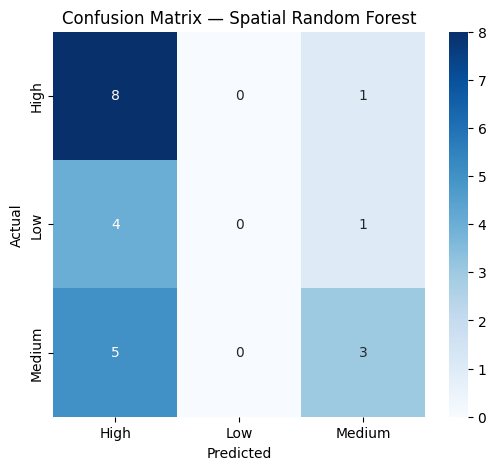

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Spatial Random Forest")
plt.show()


In [10]:
test_results = test_df.copy()

test_results["predicted_label"] = le.inverse_transform(y_pred)
test_results["true_label"] = le.inverse_transform(y_test)

test_results.head()


,state,year,cases_lag1,cases_lag2,spatial_lag_cases,risk_label,risk_encoded,predicted_label,true_label
2,Assam,2023.0,1826.0,103.0,143.0,High,0,Medium,High
3,Assam,2024.0,8208.0,1826.0,1185.5,Medium,2,High,Medium
6,Goa,2023.0,443.0,649.0,12720.0,Medium,2,Medium,Medium
7,Goa,2024.0,512.0,443.0,8578.0,Low,1,Medium,Low
10,Haryana,2023.0,8996.0,11835.0,23389.0,High,0,High,High


In [11]:
errors = test_results[
    test_results["predicted_label"] != test_results["true_label"]
]

errors[["state", "year", "true_label", "predicted_label"]].head(10)


,state,year,true_label,predicted_label
2,Assam,2023.0,High,Medium
3,Assam,2024.0,Medium,High
7,Goa,2024.0,Low,Medium
11,Haryana,2024.0,Low,High
19,Maharashtra,2024.0,Medium,High
23,Manipur,2024.0,Low,High
27,Mizoram,2024.0,Low,High
31,Odisha,2024.0,Medium,High
35,Punjab,2024.0,Low,High
39,Rajasthan,2024.0,Medium,High


In [12]:
errors["true_label"].value_counts()


true_label
Medium    5
Low       5
High      1
Name: count, dtype: int64

In [13]:
y_proba = rf_spatial.predict_proba(X_test)

# Convert to DataFrame
proba_df = pd.DataFrame(
    y_proba,
    columns=[f"prob_{c}" for c in le.classes_]
)

proba_df.head()


,prob_High,prob_Low,prob_Medium
0,0.325,0.235,0.44
1,0.980,0.000,0.02
2,0.450,0.020,0.53
3,0.460,0.020,0.52
4,0.890,0.000,0.11


In [14]:
test_results = test_results.reset_index(drop=True)
test_results = pd.concat([test_results, proba_df], axis=1)

test_results["confidence"] = test_results[
    ["prob_Low", "prob_Medium", "prob_High"]
].max(axis=1)

test_results.head()


,state,year,cases_lag1,cases_lag2,spatial_lag_cases,risk_label,risk_encoded,predicted_label,true_label,prob_High,prob_Low,prob_Medium,confidence
0,Assam,2023.0,1826.0,103.0,143.0,High,0,Medium,High,0.325,0.235,0.44,0.44
1,Assam,2024.0,8208.0,1826.0,1185.5,Medium,2,High,Medium,0.980,0.000,0.02,0.98
2,Goa,2023.0,443.0,649.0,12720.0,Medium,2,Medium,Medium,0.450,0.020,0.53,0.53
3,Goa,2024.0,512.0,443.0,8578.0,Low,1,Medium,Low,0.460,0.020,0.52,0.52
4,Haryana,2023.0,8996.0,11835.0,23389.0,High,0,High,High,0.890,0.000,0.11,0.89


In [15]:
frontend_df = test_results[[
    "state",
    "year",
    "predicted_label",
    "confidence",
    "prob_Low",
    "prob_Medium",
    "prob_High"
]].copy()

frontend_df.head()


,state,year,predicted_label,confidence,prob_Low,prob_Medium,prob_High
0,Assam,2023.0,Medium,0.44,0.235,0.44,0.325
1,Assam,2024.0,High,0.98,0.000,0.02,0.980
2,Goa,2023.0,Medium,0.53,0.020,0.53,0.450
3,Goa,2024.0,Medium,0.52,0.020,0.52,0.460
4,Haryana,2023.0,High,0.89,0.000,0.11,0.890


In [16]:
frontend_df.to_csv(
    "../outputs/tables/predicted_risk_with_confidence.csv",
    index=False
)


In [17]:
import joblib

joblib.dump(rf_spatial, "../backend/model/rf_spatial.pkl")
joblib.dump(le, "../backend/model/label_encoder.pkl")


['../backend/model/label_encoder.pkl']